In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

import sys
import gc

%matplotlib inline

In [2]:
sns.set()
plt.rcParams["figure.figsize"] = 20, 10

In [3]:
train_path = 'data/sales_train_validation.csv'
submission_path = 'data/sample_submission.csv'
calendar_path = 'data/calendar.csv' 
sell_prices_path = 'data/sell_prices.csv'

In [4]:
def rmse(y_true, y_pred):
    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
sales = pd.read_csv(train_path)

sales = sales.set_index('id').drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
sales.index = sales.index.to_series().str.rsplit('_', 1, expand=True)[0].rename('id')
sales.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


Remove days that should have no values (Xmas)

In [6]:
total_sales = sales.sum(axis=0)
outliers = total_sales.loc[total_sales < 10000].index.tolist()

In [7]:
outliers

['d_331', 'd_697', 'd_1062', 'd_1427', 'd_1792']

In [8]:
sales = sales.loc[:, ~sales.columns.isin(outliers)]
total_sales = total_sales.loc[~total_sales.index.isin(outliers)]

In [9]:
n_vals = 28

In [10]:
y_train_df, y_val_df = sales.iloc[:, :-n_vals], sales.iloc[:, -n_vals:]
y_train, y_val = y_train_df.to_numpy(), y_val_df.to_numpy()

In [11]:
total_y_train_df, total_y_val_df = total_sales.iloc[:-n_vals], total_sales.iloc[-n_vals:]
total_y_train, total_y_val = total_y_train_df.to_numpy(), total_y_val_df.to_numpy()

In [12]:
n_trains = y_train.shape[1]
print(y_train.shape)
print(y_val.shape)

(30490, 1880)
(30490, 28)


- Naive
- Seasonal Naive
    - 7 days
    - 28 days
    - 365 days
- Simple Exponential Smoothing
    - $Y_{t + 1} = \alpha * Y_t + (1 - \alpha) * Y_{t-1}$
    - $\alpha = [0.1,  0.3]$
- Moving Averages
    - 7 days
    - 28 days
    - 365 days
- ES (Top-down)
    - Last 28 days to estimate the proportion
- Arima (Top-down)
    - Last 28 days to estimate the proportion
- Average of ES and ARIMA

### Naive
$y_t = y_{t-1}$

In [13]:
last_y = y_train[:, -1].reshape(-1, 1)
y_pred_naive = np.repeat(last_y, 28, axis=1)

In [14]:
print('RMSE for Naive:', rmse(y_val, y_pred_naive))

RMSE for Naive: 3.3006656823272778


### Seasonal Naive
- 7 days
- 28 days
- 365 days

In [15]:
last_7_y = y_train[:, -7:]
y_pred_snaive_7 = np.tile(last_7_y, 4)

y_pred_snaive_28 = y_train[:, -28:]

y_pred_snaive_365 = y_train[:, -365: -365+28]

all_y_pred_snaive = [y_pred_snaive_7, y_pred_snaive_28, y_pred_snaive_365]

In [16]:
print('RMSE for sNaive lag 7:', rmse(y_val, y_pred_snaive_7))
print('RMSE for sNaive lag 28:', rmse(y_val, y_pred_snaive_28))
print('RMSE for sNaive lag 365:', rmse(y_val, y_pred_snaive_365))
print('RMSE for average sNaive:', rmse(y_val, np.sum(all_y_pred_snaive, axis=0) / 3))

RMSE for sNaive lag 7: 2.759459373384556
RMSE for sNaive lag 28: 2.836502573431586
RMSE for sNaive lag 365: 3.2955308156052854
RMSE for average sNaive: 2.3720719888331354


- Moving from Naive prediction to Seasonal Naive already improves the RMSE.
- Taking average improves significantly

### Simple Exponential Smoothing
- $Y_{(t + 1)|t} = \alpha * Y_t + (1 - \alpha) * Y_{t|t-1}$
- $\alpha = [0.1,  0.3]$

In [17]:
all_y_pred_ses = []

# Loop through each alpha to generate forecast
for alpha in [0.1, 0.2, 0.3]:
    # Get empty array to store prediction value
    y_pred_ses = np.zeros_like(y_val)
    
    # Train array to extend period by period
    y_train_ses = y_train.copy()
    
    # Predict period by period
    for i in range(n_vals):
        # Get the smoothing coefficients
        power_arr = np.arange(0, n_trains + i)[::-1]
        coeff = (alpha * np.power(alpha, power_arr)).reshape(1, -1)
        
        # Get predicton
        this_ses = np.multiply(y_train_ses, coeff).sum(axis=1)
        
        # Add back to the array
        y_train_ses = np.concatenate([y_train_ses, this_ses.reshape(-1, 1)], axis=1)
        y_pred_ses[:, i] = this_ses
    
    print(f'RMSE for SES with alpha {alpha}:', rmse(y_val, y_pred_ses))
    
    all_y_pred_ses.append(y_pred_ses)
    
print(f'RMSE for average SES:', rmse(y_val, np.sum(all_y_pred_ses, axis=0) / 3))

RMSE for SES with alpha 0.1: 3.843489320643054
RMSE for SES with alpha 0.2: 3.826296194317618
RMSE for SES with alpha 0.3: 3.78677720874057
RMSE for average SES: 3.815925573709549


- The SES doesn't work so well compared to other benchmarks
- Its usage is more appropriate for data with no clear trend and seasonality
- The sales data that we have clearly exhibits trend and seasonality

### Moving Averages
- 7 days
- 28 days
- 365 days

In [18]:
all_y_pred_ma = []

# Loop through each alpha to generate forecast
for window in [7, 28, 365]:
    # Get empty array to store prediction value
    y_pred_ma = np.zeros_like(y_val)
    
    # Train array to extend period by period
    y_train_ma = y_train.copy()
    
    # Predict period by period
    for i in range(n_vals):
        # Get predicton
        this_ma = y_train_ma[:, -window:].mean(axis=1)
        
        # Add back to the array
        y_train_ma = np.concatenate([y_train_ma, this_ma.reshape(-1, 1)], axis=1)
        y_pred_ma[:, i] = this_ma
    
    print(f'RMSE for MA with window {window}:', rmse(y_val, y_pred_ma))
    
    all_y_pred_ma.append(y_pred_ma)
    
print(f'RMSE for average MA:', rmse(y_val, np.sum(all_y_pred_ma, axis=0) / 3))

RMSE for MA with window 7: 2.432393755252872
RMSE for MA with window 28: 2.2564704424620996
RMSE for MA with window 365: 2.3837651161432776
RMSE for average MA: 2.2307152780289297


- Moving Average is able to take in account the trend and performs pretty well

### ES and SARIMA (Top-down)
- Estimate the total sales with ES and ARIMA
- Distribute using proportion of sales to get the lowest level
- Last 28 days to estimate the proportion

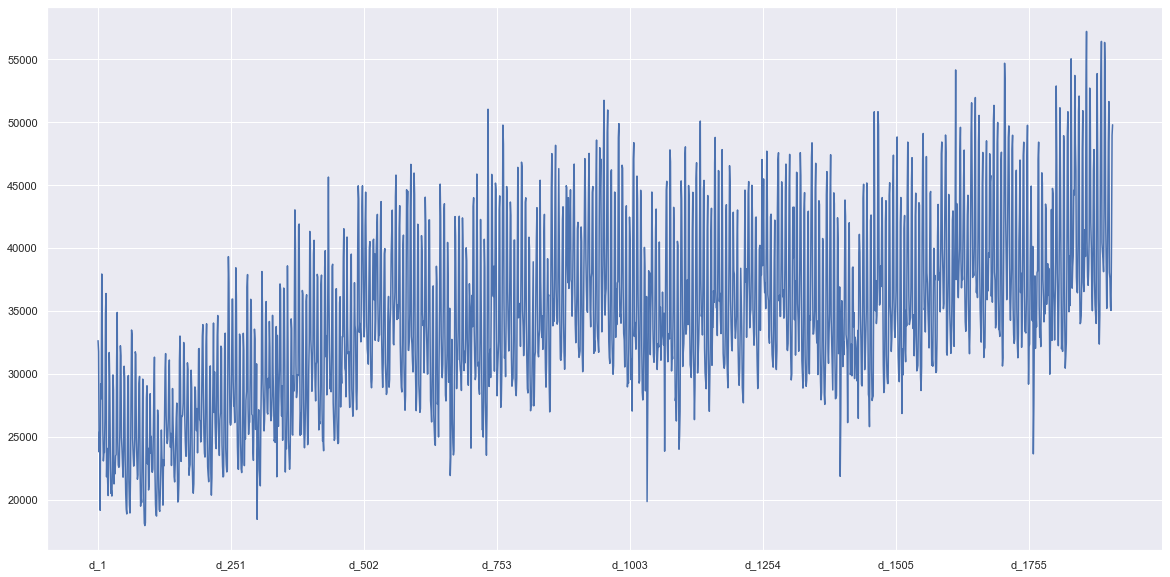

In [19]:
total_sales.plot()

In [20]:
proportion = np.divide(y_train, total_y_train)[:, -28:].mean(axis=1).reshape(-1, 1)

#### ES

In [21]:
all_y_pred_es = []
for seasonality in [7, 28, 365]:
    es = ExponentialSmoothing(total_y_train, trend='add', damped=True, seasonal='add', seasonal_periods=seasonality)
    es.fit()
    pred_es = es.predict(es.params, start=n_trains + 1, end=n_trains + 28)
    y_pred_es = np.multiply(proportion, pred_es)
    
    print(f'RMSE for top-down ES with seasonality cycle of {seasonality} days:', rmse(y_val, y_pred_es))
    
    all_y_pred_es.append(y_pred_es)
    
print(f'RMSE for average top-down ES:', rmse(y_val, np.sum(all_y_pred_es, axis=0) / 3))

C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


RMSE for top-down ES with seasonality cycle of 7 days: 2.204266756149011


C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


RMSE for top-down ES with seasonality cycle of 28 days: 2.2104859180237875


C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\yarge\Miniconda3\envs\kaggle\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


RMSE for top-down ES with seasonality cycle of 365 days: 2.236869275772968
RMSE for average top-down ES: 2.1958555987347532


#### SARIMA

In [25]:
model = SARIMAX(
    total_y_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
result = model.fit()
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5337      0.024     22.233      0.000       0.487       0.581
ma.L1         -0.9990      0.007   -140.685      0.000      -1.013      -0.985
ar.S.L7       -0.0318      0.051     -0.627      0.531      -0.131       0.068
ma.S.L7       -0.6972      0.038    -18.520      0.000      -0.771      -0.623
sigma2      1.406e+07   3.57e-10   3.94e+16      0.000    1.41e+07    1.41e+07


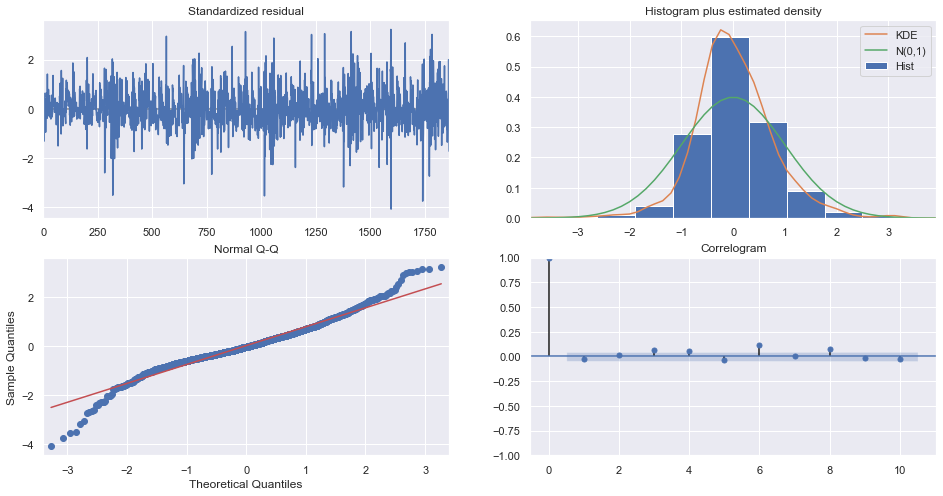

In [27]:
result.plot_diagnostics(figsize=(16, 8));

In [28]:
pred_arima = result.predict(start=n_trains + 1, end=n_trains + 28)
y_pred_sarima = np.multiply(proportion, pred_arima)

print(f'RMSE for SARIMA:', rmse(y_val, y_pred_sarima))

RMSE for SARIMA: 2.207018275799055
